# FLO Gözetimsiz Öğrenme ile Müşteri
# Segmentasyonu
**İş Problemi**
> FLO müşterilerini segmentlere ayırıp bu segmentlere göre
> pazarlama stratejileri belirlemek istiyor. Buna yönelik
> olarak müşterilerin davranışları tanımlanacak ve bu
> davranışlardaki öbeklenmelere göre gruplar oluşturulacak.

**Veri Seti Hikayesi**
>Veri seti Flo’dan son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan)
olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.
12 Değişken 19.945 Gözlem 2.7MB*
*  master_id: Eşsiz müşteri numarası
*  order_channel: Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile)
*  last_order_channel: En son alışverişin yapıldığı kanal
*  first_order_date: Müşterinin yaptığı ilk alışveriş tarihi
*  last_order_date: Müşterinin yaptığı son alışveriş tarihi
*  last_order_date_online: Müşterinin online platformda yaptığı son alışveriş tarihi
*  last_order_date_offline: Müşterinin offline platformda yaptığı son alışveriş tarihi
*  order_num_total_ever_online: Müşterinin online platformda yaptığı toplam alışveriş sayısı
*  order_num_total_ever_offline: Müşterinin offline'da yaptığı toplam alışveriş sayısı
*  customer_value_total_ever_offline: Müşterinin offline alışverişlerinde ödediği toplam ücret
*  customer_value_total_ever_online: Müşterinin online alışverişlerinde ödediği toplam ücret
*  interested_in_categories_12: Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df = pd.read_csv("/kaggle/input/flo-unsupervised/flo_data_20k.csv")
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [4]:
df.head()
df.shape
df.info()
df.describe().T      # aykırı değere sahip veriler var
df.isnull().sum()    # eksik veri yok

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


(19945, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [5]:
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

df["last_order_date"].max()
analysis_date = dt.datetime(2021, 6, 1)

Timestamp('2021-05-30 00:00:00')

In [6]:
df["recency"] = (analysis_date - df["last_order_date"]).dt.days
df["tenure"] = (df["last_order_date"] - df["first_order_date"]).dt.days

model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.0000,1.0000,139.9900,799.3800,95,119
1,19.0000,2.0000,159.9700,1853.5800,105,1469
2,3.0000,2.0000,189.9700,395.3500,186,366
3,1.0000,1.0000,39.9900,81.9800,135,11
4,1.0000,1.0000,49.9900,159.9900,86,582


In [7]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

<Figure size 900x900 with 0 Axes>

<Axes: >

/tmp/ipykernel_18/4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)


<Axes: >

/tmp/ipykernel_18/4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)


<Axes: >

/tmp/ipykernel_18/4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)


<Axes: >

/tmp/ipykernel_18/4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)


<Axes: >

/tmp/ipykernel_18/4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)


<Axes: >

/tmp/ipykernel_18/4200321661.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column],color = "g")
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


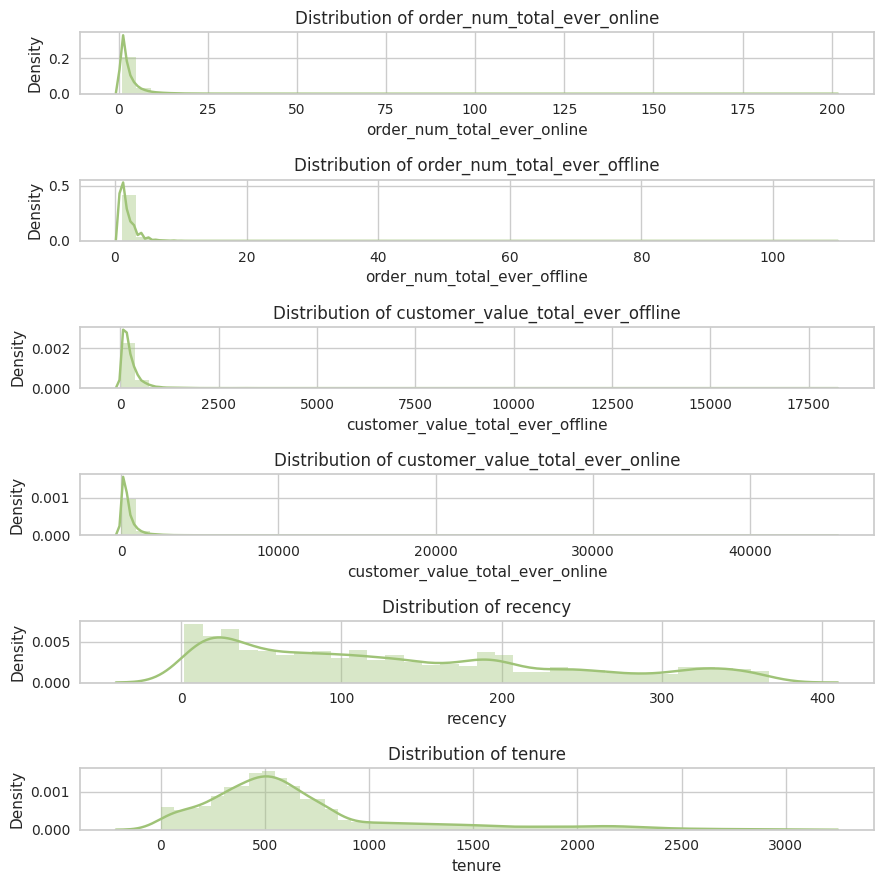

In [8]:
plt.figure(figsize=(9, 9))
plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')
plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')
plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')
plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')
plt.subplot(6, 1, 5)
check_skew(model_df,'recency')
plt.subplot(6, 1, 6)
check_skew(model_df,'tenure')
plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)
plt.show()

In [9]:
model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
model_df['customer_value_total_ever_offline']=np.log1p(model_df['customer_value_total_ever_offline'])
model_df['customer_value_total_ever_online']=np.log1p(model_df['customer_value_total_ever_online'])
model_df['recency']=np.log1p(model_df['recency'])
model_df['tenure']=np.log1p(model_df['tenure'])
model_df.head()

/tmp/ipykernel_18/1844814189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_online']=np.log1p(model_df['order_num_total_ever_online'])
/tmp/ipykernel_18/1844814189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['order_num_total_ever_offline']=np.log1p(model_df['order_num_total_ever_offline'])
/tmp/ipykernel_18/1844814189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.6094,0.6931,4.9487,6.6851,4.5643,4.7875
1,2.9957,1.0986,5.0812,7.5254,4.6634,7.2930
2,1.3863,1.0986,5.2521,5.9823,5.2311,5.9054
3,0.6931,0.6931,3.7133,4.4186,4.9127,2.4849
4,0.6931,0.6931,3.9316,5.0813,4.4659,6.3682


In [10]:
scale = MinMaxScaler((0,1))
#scale = StandardScaler()
model_scaling = scale.fit_transform(model_df)  #numpy arrayi döner
model_df = pd.DataFrame(model_scaling, columns= model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.1988,0.0000,0.3444,0.5008,0.7206,0.5971
1,0.4995,0.1012,0.3623,0.6048,0.7412,0.9096
2,0.1504,0.1012,0.3853,0.4138,0.8592,0.7365
3,0.0000,0.0000,0.1776,0.2203,0.7930,0.3099
4,0.0000,0.0000,0.2071,0.3023,0.7001,0.7942


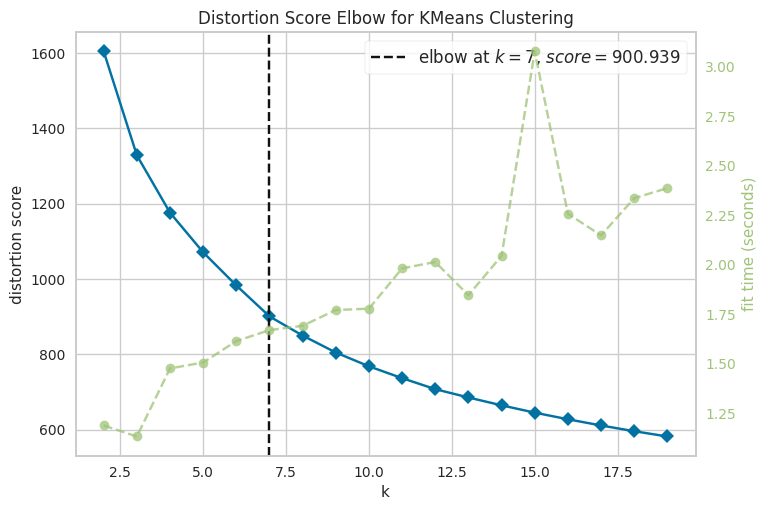

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

7

In [11]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2,20)).fit(model_df)
elbow.show()

elbow.elbow_value_

In [12]:
k_means = KMeans(n_clusters = elbow.elbow_value_, random_state = 40).fit(model_df)

k_means.cluster_centers_
k_means.inertia_
k_means.labels_

cust_segments = k_means.labels_

final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = cust_segments

array([[0.03536445, 0.0274037 , 0.32119368, 0.31019213, 0.88557808,
        0.74410405],
       [0.30297286, 0.08551401, 0.38989371, 0.54345183, 0.46509114,
        0.83427311],
       [0.08088832, 0.08588915, 0.39629394, 0.37151045, 0.24541523,
        0.78214307],
       [0.04859695, 0.04459559, 0.3505692 , 0.32932916, 0.57173934,
        0.77865137],
       [0.0612478 , 0.19273537, 0.50679964, 0.34020198, 0.7906711 ,
        0.80126099],
       [0.03035762, 0.01233954, 0.35357719, 0.31893167, 0.7483166 ,
        0.395232  ],
       [0.25791274, 0.04967979, 0.34534572, 0.50580499, 0.83012951,
        0.82737661]])

900.9439003458177

array([6, 6, 6, ..., 2, 4, 0], dtype=int32)

/tmp/ipykernel_18/403725061.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = cust_segments


In [13]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online                 order_num_total_ever_offline                 customer_value_total_ever_offline                     customer_value_total_ever_online                      recency            tenure                
                               mean    min      max                         mean    min      max                              mean      min        max                             mean      min        max     mean min  max     mean min   max count
segment                                                                                                                                                                                                                                               
0                            1.4285 1.0000   5.0000                       1.2773 1.0000   5.0000                          144.4205  10.0000   829.9800                         211.6496  12.9900  1519.1700 226.0357  88  367 490.1179  52  2820  5456
1                            8.5789 2.0000 200.0000                       2.0944 1.0000  36.0000                          279.1181  12.9900  3589.6500                        1468.6134 265.9700 45220.1300  32.0812   2  109 966.5028  18  3034  1971
2                            2.1680 1.0000  11.0000                       2.0955 1.0000  14.0000                          293.1946  12.9900  3425.1400                         371.6160  23.9900  3444.0800  10.0344   2   27 662.6568   2  2962  1833
3                            1.6083 1.0000   6.0000                       1.4794 1.0000   6.0000                          185.8527  12.9900  1406.8500                         249.5788  14.0000  1307.3300  50.5431  15  109 604.3235  51  2828  3342
4                            1.8234 1.0000  13.0000                       3.7588 1.0000 109.0000                          549.9975 106.8200 18119.1400                         281.7203  14.9900  2587.2000 153.7649  22  366 728.2818  20  2911  3279
5                            1.4044 1.0000   8.0000                       1.1295 1.0000   6.0000                          192.6059  12.9900  1333.0000                         250.5054  19.9900  3476.8100 139.3462   4  367  37.0278   0   132   826
6                            6.4407 1.0000  55.0000                       1.5544 1.0000  16.0000                          186.9384  10.4900  1644.7900                         995.5963 180.9600 12038.1800 178.7171  55  367 947.5704  26  2964  3238

<Figure size 700x500 with 0 Axes>

Text(0.5, 1.0, 'Dendrograms')

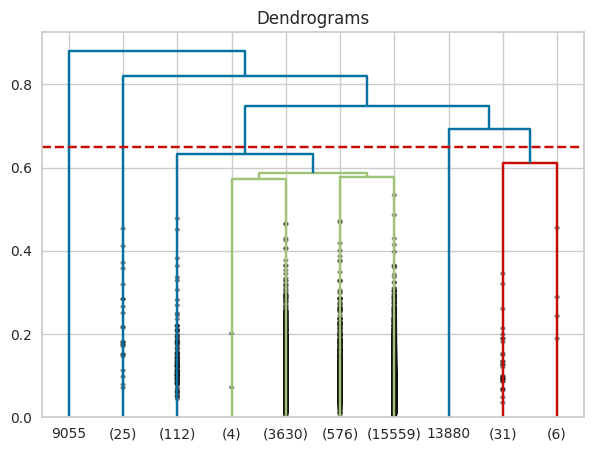

In [14]:
hc_average = linkage(model_df, 'average')

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=0.65, color='r', linestyle='--')    #çizgi atma işini yapan satır
plt.show()

In [15]:
hc = AgglomerativeClustering(n_clusters=5)
segments = hc.fit_predict(model_df)

final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df["segment"] = final_df["segment"] + 1
final_df.head()

/tmp/ipykernel_18/3443624036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = segments
/tmp/ipykernel_18/3443624036.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = final_df["segment"] + 1


,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.0000,1.0000,139.9900,799.3800,95,119,4
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.0000,2.0000,159.9700,1853.5800,105,1469,3
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.0000,2.0000,189.9700,395.3500,186,366,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.0000,1.0000,39.9900,81.9800,135,11,4
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.0000,1.0000,49.9900,159.9900,86,582,1


In [16]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online                 order_num_total_ever_offline                 customer_value_total_ever_offline                    customer_value_total_ever_online                      recency            tenure                 
                               mean    min      max                         mean    min      max                              mean     min        max                             mean      min        max     mean min  max     mean  min   max count
segment                                                                                                                                                                                                                                               
1                            1.3711 1.0000  13.0000                       1.9878 1.0000 109.0000                          261.9665 10.4900 18119.1400                         208.0685  12.9900 30688.4700 183.0273  18  367 569.7232    3  2911  8747
2                            3.7539 1.0000  49.0000                       1.8170 1.0000  24.0000                          240.9836 12.9900  3425.1400                         638.6138  19.9900 12545.3700  23.9622   2  108 715.0657   18  3034  4994
3                            6.9057 1.0000 200.0000                       3.0772 1.0000  16.0000                          427.1183 12.9900  2963.2400                        1104.1246 139.9800 45220.1300 131.5739  14  365 914.4871  109  3016  2396
4                            1.3970 1.0000   6.0000                       1.1990 1.0000   6.0000                          200.6907 12.9900  1019.9700                         227.4241  26.9900  1389.6000  92.5157   4  367  80.2579    0   555   985
5                            4.7411 1.0000  24.0000                       1.1187 1.0000   4.0000                          123.4635 10.0000  1049.9200                         722.7679  59.9800  7665.2800 196.5236  36  367 876.9539   71  2964  2823